## Compare likelihoods using different theory objects

In this notebook we show some example syntax for the new 'full likelihood'. The likelihood object remains pretty much the same, but here we use a new FullTheory object that replaces LyaTheory which deals with the mapping from a set of likelihood parameters (like_params=[..]) to a set of emulator calls and a P1DP1D in velocity units. The FullTheory object works in Planck units, i.e. ω2bωb2, ω2cωc2, AsAs, nsns so far, we can add more later on. It uses CAMB to map these parameters directly into a set of emulator calls Δ2pΔp2, npnp, etc at each zz where we have data.

NB that there is a bit of duplicate code in this iteration which can be tidied up eventually, in that the syntax I use to fit the emulator calls is also found in fit_linP, however there the comoving linear power is calculated at each zz independently, and I thought it might be faster to give all zzs to CAMB to calculate at once. If it is faster this way, this will matter when it comes to sampling. The other point to note is that I do not currently calculate fpfp, which is done in the fit_linP fits, and I do that as we have not yet trained the emulator on it so I do not yet want to slow down likelihood evaluations calculating an expensive quantitity that is not used.

Also to avoid calling CAMB twice in different parts of the code, get_emulator_calls() now also has an option return_M_of_z which will give M(z)M(z) for each emulator call, which is then used to convert the comoving P1DP1D into velocity units.

First we set up a data object and an emulator as normal.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
# our modules
import data_MPGADGET
import p1d_arxiv
import gp_emulator
import likelihood
import likelihood_parameter
import lya_theory
import full_theory
import camb_cosmo
import CAMB_model
import fit_linP

In [2]:
# specify verbosity for all objects (except emulator)
verbose=False

### Setup mock data, from one of simulations in the suite

In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,basedir=basedir,skewers_label=skewers_label,data_cov_factor=1)

### Setup archive of P1D measurements from simulations and train the emulator

In [4]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


### Setup relevant cosmology objects

In [6]:
# Fiducial cosmology 
cosmo_fid=camb_cosmo.get_cosmology()
camb_cosmo.print_info(cosmo_fid)
# compute linP parameters
linP_fid=fit_linP.LinearPowerModel(cosmo=cosmo_fid)
old_like_params_fid=linP_fid.get_likelihood_parameters()
print('old likelihood parameters')
for par in old_like_params_fid:
    print(par.info_str())
# setup camb model (needed in full_theory)
camb_model_fid=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_fid)
new_like_params_fid=camb_model_fid.get_likelihood_parameters()
print('new likelihood parameters')
for par in new_like_params_fid:
    print(par.info_str())

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
old likelihood parameters
g_star = 0.9677508579459803
f_star = 0.981369557840318
Delta2_star = 0.36017590528641974
n_star = -2.299335667257498
alpha_star = -0.2165270371206895
new likelihood parameters
ombh2 = 0.022
omch2 = 0.12
As = 2.1e-09
ns = 0.965
H0 = 67.0
mnu = 0.0


In [7]:
# Test cosmology
cosmo_fid=camb_cosmo.get_cosmology(As=1.9e-9,ns=0.92)
camb_cosmo.print_info(cosmo_fid)
# compute linP parameters
linP_fid=fit_linP.LinearPowerModel(cosmo=cosmo_fid)
old_like_params_fid=linP_fid.get_likelihood_parameters()
print('old likelihood parameters')
for par in old_like_params_fid:
    print(par.info_str())
# setup camb model (needed in full_theory)
camb_model_fid=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_fid)
new_like_params_fid=camb_model_fid.get_likelihood_parameters()
print('new likelihood parameters')
for par in new_like_params_fid:
    print(par.info_str())

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 1.9000E-09, n_s = 9.2000E-01, alpha_s = 0.0000E+00
old likelihood parameters
g_star = 0.9677508579459803
f_star = 0.9813695578403181
Delta2_star = 0.28957717426109336
n_star = -2.344335667257508
alpha_star = -0.21652703712062632
new likelihood parameters
ombh2 = 0.022
omch2 = 0.12
As = 1.9e-09
ns = 0.92
H0 = 67.0
mnu = 0.0


### Setup and compare theory objects for fiducial cosmology

Start by setting up an old theory object, that uses only compressed linP parameters

In [8]:
old_theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=cosmo_fid,verbose=verbose)
old_emu_calls_fid=old_theory.get_emulator_calls()

Setup now a new theory object, that holds a CAMB object

In [9]:
new_theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_fid,verbose=verbose)
new_emu_calls_fid=new_theory.get_emulator_calls(return_M_of_z=False)

In [10]:
print("z=2 emulator calls for old theory = ", old_emu_calls_fid[0])
print("z=2 emulator calls for new theory = ", new_emu_calls_fid[0])

z=2 emulator calls for old theory =  {'Delta2_p': 0.5064267652676698, 'n_p': -2.3443906373822965, 'alpha_p': -0.216419711968611, 'f_p': 0.9583569136684355, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z=2 emulator calls for new theory =  {'Delta2_p': 0.5065830386051876, 'n_p': -2.3444471404944625, 'alpha_p': -0.2165293646872646, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}


Note that the numbers above are not supposed to exactly match, since kp_Mpc is slightly different in both theories

### Compare now emulator calls for the test cosmology

In [11]:
# call the old theory, but using the freshly computed likelihood parameters from the test cosmology
old_emu_calls_fid=old_theory.get_emulator_calls(like_params=old_like_params_fid)

In [12]:
# we want to study also cases where we ignore some of the parameters (although here we expect equal results)
cull_params=['f_star','g_star','alpha_star']
culled_like_params_fid = [par for par in old_like_params_fid if par.name not in cull_params]
for par in culled_like_params_fid:
    print(par.info_str())
# same, but using only the culled parameters
culled_emu_calls_fid=old_theory.get_emulator_calls(like_params=culled_like_params_fid)

Delta2_star = 0.28957717426109336
n_star = -2.344335667257508


In [13]:
# call the new theory, but using the freshly computed likelihood parameters for the test cosmology
new_emu_calls_fid=new_theory.get_emulator_calls(like_params=new_like_params_fid,return_M_of_z=False)

In [14]:
print("z = {} emulator calls from old theory = {}".format(data.z[0],old_emu_calls_fid[0]))
print("z = {} emulator calls from culled theory = {}".format(data.z[0],culled_emu_calls_fid[0]))
print("z = {} emulator calls from new theory = {}".format(data.z[0],new_emu_calls_fid[0]))

z = 2.0 emulator calls from old theory = {'Delta2_p': 0.5064267652676698, 'n_p': -2.3443906373822965, 'alpha_p': -0.216419711968611, 'f_p': 0.9583569136684355, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z = 2.0 emulator calls from culled theory = {'Delta2_p': 0.5064267652676698, 'n_p': -2.3443906373822965, 'alpha_p': -0.216419711968611, 'f_p': 0.9583569136684355, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z = 2.0 emulator calls from new theory = {'Delta2_p': 0.5065830386051876, 'n_p': -2.3444471404944625, 'alpha_p': -0.2165293646872646, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}


In [15]:
print("z = {} emulator calls from old theory = {}".format(data.z[-1],old_emu_calls_fid[-1]))
print("z = {} emulator calls from culled theory = {}".format(data.z[-1],culled_emu_calls_fid[-1]))
print("z = {} emulator calls from new theory = {}".format(data.z[-1],new_emu_calls_fid[-1]))

z = 4.0 emulator calls from old theory = {'Delta2_p': 0.18647660978029978, 'n_p': -2.3443214163657147, 'alpha_p': -0.21645454121142435, 'f_p': 0.9898232760729389, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}
z = 4.0 emulator calls from culled theory = {'Delta2_p': 0.18647660978029978, 'n_p': -2.3443214163657147, 'alpha_p': -0.21645454121142435, 'f_p': 0.9898232760729389, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}
z = 4.0 emulator calls from new theory = {'Delta2_p': 0.18656800445888588, 'n_p': -2.3444470585921673, 'alpha_p': -0.2165299303656281, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}


Both new and old theories make the same emulator call for a theory that is not the fiducial!

## Test now the likelihood objects

### Old likelihood using all five parameters

In [16]:
## Set up a likelihood object with the old theory object
#old_free_params=['Delta2_star','n_star']
old_free_params=['Delta2_star','n_star','alpha_star','f_star','g_star']
old_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_parameters=old_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [17]:
# get parameter values in cube for test cosmology
old_values_fid=old_like.sampling_point_from_parameters(old_like_params_fid)
# check that parameters inferred from these are same than computed before
for par in old_like.parameters_from_sampling_point(values=old_values_fid):
    print(par.info_str(),',',par.value_in_cube())
old_like.get_log_like(values=old_values_fid,ignore_log_det_cov=False)

g_star = 0.9677508579459803 , 0.4437714486495072
f_star = 0.9813695578403181 , 0.7842389460079529
Delta2_star = 0.28957717426109336 , 0.26384782840728904
n_star = -2.344335667257508 , 0.056643327424921126
alpha_star = -0.21652703712062632 , 0.48611784435794264


45.542155196238575

### Old likelihood using only two parameters (should not make a different, no change in growth / expansion)

In [18]:
## Set up a likelihood object with the old theory object, but now with only 2 key parameters
culled_free_params=['Delta2_star','n_star']
culled_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_parameters=culled_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [19]:
# get parameter values in cube for test cosmology
culled_values_fid=culled_like.sampling_point_from_parameters(culled_like_params_fid)
# check that parameters inferred from these are same than computed before
for par in culled_like.parameters_from_sampling_point(values=culled_values_fid):
    print(par.info_str(),',',par.value_in_cube())
culled_like.get_log_like(values=culled_values_fid,ignore_log_det_cov=False)

Delta2_star = 0.28957717426109336 , 0.26384782840728904
n_star = -2.344335667257508 , 0.056643327424921126


45.542155196238575

### New likelihood

In [20]:
## Set up a likelihood object with the new theory object
new_free_params=["As","ns","mnu"]
new_like=likelihood.Likelihood(data=data,theory=new_theory,
                            free_parameters=new_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [21]:
# get parameter values in cube for test cosmology in new theory
new_values_fid=new_like.sampling_point_from_parameters(new_like_params_fid)
# check that parameters inferred from these are same than computed before
for par in new_like.parameters_from_sampling_point(values=new_values_fid):
    print(par.info_str(),',',par.value_in_cube())

As = 1.9e-09 , -0.500000000000001
ns = 0.92 , -0.9999999999999963
mnu = 0.0 , 0.0


In [22]:
new_like.get_log_like(values=new_values_fid,ignore_log_det_cov=False)

45.90151761023667

### P1D predictions from the different theories

In [23]:
zs=data.z
k_kms=np.logspace(np.log10(min(data.k)),np.log10(max(data.k)),500)
old_p1d=old_like.get_p1d_kms(k_kms=k_kms,values=old_values_fid,return_covar=False)

In [24]:
culled_p1d=culled_like.get_p1d_kms(k_kms=k_kms,values=culled_values_fid,return_covar=False)

In [25]:
new_p1d=new_like.get_p1d_kms(k_kms=k_kms,values=new_values_fid,return_covar=False)

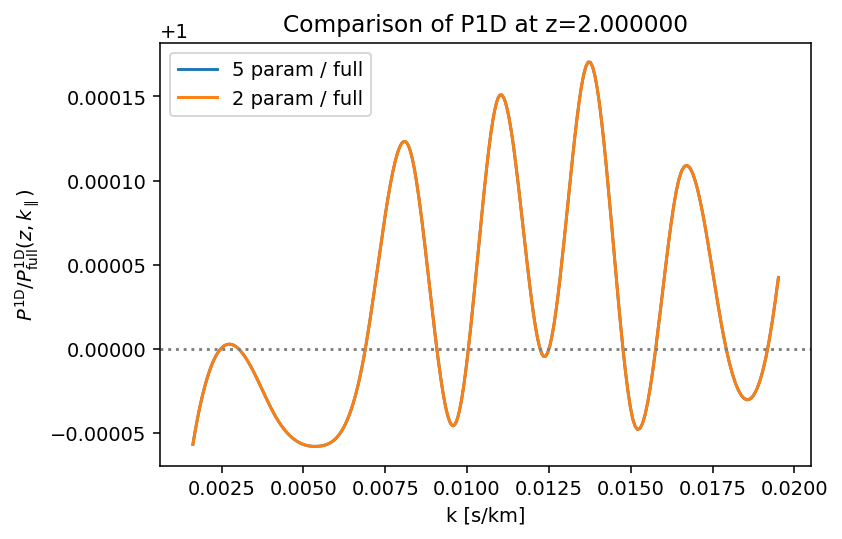

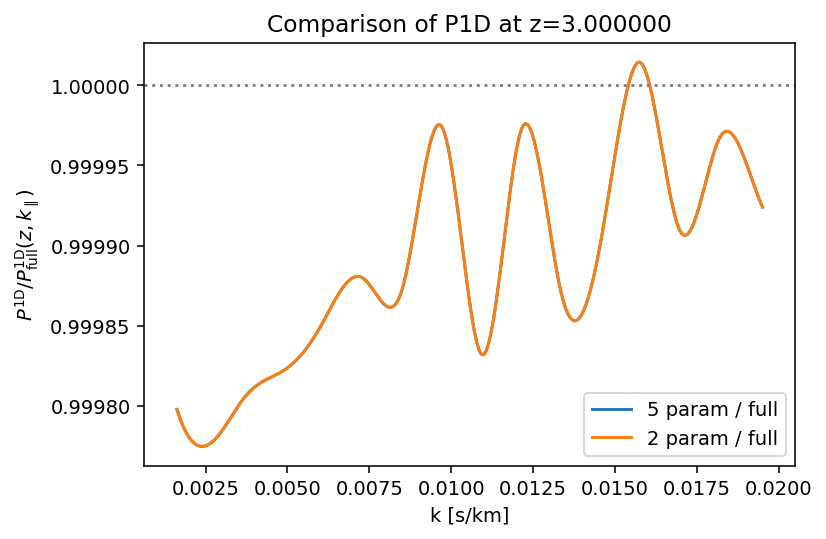

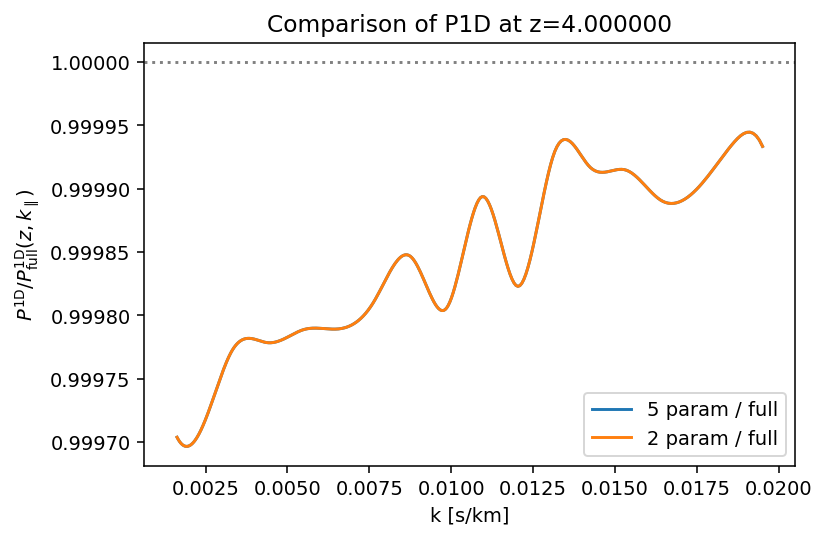

In [26]:
for iz in range(0,len(zs),4):
    z=zs[iz]
    plt.figure()
    plt.plot(k_kms,old_p1d[iz]/new_p1d[iz],label='5 param / full')
    plt.plot(k_kms,culled_p1d[iz]/new_p1d[iz],label='2 param / full')
    plt.legend()
    plt.xlabel('k [s/km]')
    plt.ylabel(r'$P^{\rm 1D} / P^{\rm 1D}_{\rm full} (z,k_\parallel)$')
    plt.xlim(min(k_kms)-0.001,max(k_kms)+0.001)
    plt.axhline(y=1,ls=':',color='gray')
    #plt.tight_layout()
    plt.title('Comparison of P1D at z=%f'%z)

I think these plots look pretty good!